In [1]:
%run include/utils.py
%matplotlib inline 

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def draw_points(X, N1, xlim_, ylim_, title_='', W=None):
    plt.figure()
    plt.plot(X[:N1,0],X[:N1,1], 'b+')
    plt.plot(X[N1:,0],X[N1:,1], 'r*')
    plt.title(title_)
    plt.xlim(xlim_)
    plt.ylim(ylim_)
    
    if W is not None:
        x_ = np.arange(np.min(X),np.max(X),1e-2)
        y_ = (-x_*W[1]-W[0])/W[2]
        plt.plot(x_, y_, 'm-')

## Data Generation

In [3]:
# cluster centers and respective variances
def gen_data(N1=50, N2=50, N_outlier=0, draw=False):
    center1 = np.array([4,6])
    center2 = np.array([6,4])
    outlier_center = np.array([9,2])
    var1 = np.array([1,3])
    var2 = np.array([3,1])
    var_outlier = np.array([0.5,0.5])

    # data stay in rows
    S1 = np.tile(center1.reshape((-1,1)),N1).transpose() + np.random.random((N1,len(center1)))*var1
    S2 = np.tile(center2.reshape((-1,1)),N2).transpose() + np.random.random((N2,len(center2)))*var2
    outliers = np.tile(outlier_center.reshape((-1,1)),N_outlier).transpose() + np.random.random((N_outlier,2))*var_outlier
    N2 += N_outlier
    S2 = np.vstack((S2,outliers))

    X = np.vstack((S1,S2))
    R = np.hstack((np.zeros(len(S1)),np.ones(len(S2))))
    
    if draw:
        draw_points(X, N1, [0,10], [0,10])
    
    return X, R, N1, N2, 


def gen_data_gauss(N11=50, N12=50, N2=50, draw=False,
                  center11 = np.array([2,8]),
                  center12 = np.array([5,5]),
                  center2 = np.array([8,2]),
                  var11 = np.array([1.2,1,1,1.2]).reshape((2,2)),
                  var12 = np.array([1.2,1,1,1.2]).reshape((2,2)),
                  var2 = np.array([1.0,1,1,1.0]).reshape((2,2))):
    # data stay in rows
    S11 = np.random.multivariate_normal(center11,var11,(N11))
    S12 = np.random.multivariate_normal(center12,var12,(N12))
    S2 = np.random.multivariate_normal(center2,var2,(N2))
    S1 = np.vstack((S11,S12))
    N1 = N11+N12
    # data matrix
    X = np.vstack((S1,S2))
    R = np.hstack((np.zeros(len(S1)),np.ones(len(S2))))
    if draw:
        draw_points(X, N1, [-2,12], [-2,12], title_="data points")
    return X, R, N1, N2


'''
def gen_data_gauss(N11=50, N2=50, N12=50, draw=False):
    # cluster centers and respective variances
    center1 = np.array([2,8])
    center2 = np.array([5,5])
    center3 = np.array([8,2])
    var1 = np.array([1.0,1,1,1.0]).reshape((2,2))
    var2 = np.array([2,1,1,2]).reshape((2,2))
    var3 = np.array([1.0,1,1,1.0]).reshape((2,2))
    # data stay in rows
    S1 = np.random.multivariate_normal(center1,var1,(N11))
    S2 = np.random.multivariate_normal(center2,var2,(N2))
    S3 = np.random.multivariate_normal(center3,var3,(N12))
    S1 = np.vstack((S1,S3))
    N1 = N11+N12
    # data matrix
    X = np.vstack((S1,S2))
    R = np.hstack((np.zeros(len(S1)),np.ones(len(S2))))
    if draw:
        draw_points(X, N1, [-2,12], [-2,12], title_="data points")
    return X, N1
'''

'\ndef gen_data_gauss(N11=50, N2=50, N12=50, draw=False):\n    # cluster centers and respective variances\n    center1 = np.array([2,8])\n    center2 = np.array([5,5])\n    center3 = np.array([8,2])\n    var1 = np.array([1.0,1,1,1.0]).reshape((2,2))\n    var2 = np.array([2,1,1,2]).reshape((2,2))\n    var3 = np.array([1.0,1,1,1.0]).reshape((2,2))\n    # data stay in rows\n    S1 = np.random.multivariate_normal(center1,var1,(N11))\n    S2 = np.random.multivariate_normal(center2,var2,(N2))\n    S3 = np.random.multivariate_normal(center3,var3,(N12))\n    S1 = np.vstack((S1,S3))\n    N1 = N11+N12\n    # data matrix\n    X = np.vstack((S1,S2))\n    R = np.hstack((np.zeros(len(S1)),np.ones(len(S2))))\n    if draw:\n        draw_points(X, N1, [-2,12], [-2,12], title_="data points")\n    return X, N1\n'

## 1- Least Squares for Classification

A discriminant is a function that takes an input vector $\mathbf{x}$ and assigns it to one of $K$ classes, denoted as $C_k$.

In linear regression, we considered models that were linear functions of the parameters, and we saw that the minimization of a sum-of-squares error function led to a simple closed-form solution for the parameter values. It is therefore tempting to see if we can apply the same formalism to classification problems. Consider a general classification problem with $K$ classes, with a 1-of-$K$ binary coding scheme for the target vector $\mathbf{t}$.

Each class $C_k$ is described by its own linear model so that
\begin{align}
    y_k(\mathbf{x}) &= \mathbf{w}^T\mathbf{x} + w_{k0} \\
    \mathbf{y}(\mathbf{x}) &= \tilde{\mathbf{W}}^T\tilde{\mathbf{x}}
\end{align}
where $\tilde{\mathbf{W}}$ is a matrix whose $k$'th column comprises $D+1$ dimensional vector $\tilde{\mathbf{w}}_k = (w_{k0}, \mathbf{w}^T_k)^T$ and $\tilde{\mathbf{x}}$ is the corresponding augmented vector $(1,\mathbf{x}^T)^T$. A new input $\mathbf{x}$ is then assigned to the class for which the output $y_k = \tilde{\mathbf{w}}_k^T\tilde{\mathbf{x}}$ is largest.

The parameter matrix $\tilde{\mathbf{W}}$ can be determined by minimizing sum-of-squares error function. Consider a data set $\{\mathbf{x}_n, \mathbf{y}_n\}$ where $n=1,\ldots,N$. We define a matrix $\mathbf{T}$ whose $n$'th row is the vector $t_n^T$. Also, we define $\tilde{\mathbf{X}}$ whose $n$'th row is $\tilde{\mathbf{x}}^T$. Then, sum of squares error function becomes

\begin{align}
E_D(\tilde{\mathbf{W}}) &= \frac{1}{2} \text{Tr} \left\{ (\tilde{\mathbf{X}}\tilde{\mathbf{W}}-\mathbf{T})^T(\tilde{\mathbf{X}}\tilde{\mathbf{W}}-\mathbf{T}) \right\} \\
&= \frac{1}{2} \text{Tr} \left\{ \tilde{\mathbf{W}}^T\tilde{\mathbf{X}}^T\tilde{\mathbf{X}}\tilde{\mathbf{W}} - \tilde{\mathbf{W}}^T\tilde{\mathbf{X}}^T\mathbf{T} - \mathbf{T}^T\tilde{\mathbf{X}}\tilde{\mathbf{W}} + \mathbf{T}^T\mathbf{T}  \right\}
\end{align}

Setting the derivative wrt $\tilde{\mathbf{W}}$ to zero, 
\begin{align}
0 &= \frac{\partial E_D(\tilde{\mathbf{W}})}{\partial \tilde{\mathbf{W}}} \\
0 &= \tilde{\mathbf{W}}^T\tilde{\mathbf{X}}^T\tilde{\mathbf{X}} - \mathbf{T}^T\tilde{\mathbf{X}} \\
  \tilde{\mathbf{X}}^T\mathbf{T} &= \tilde{\mathbf{X}}^T \tilde{\mathbf{X}} \tilde{\mathbf{W}} \\
  \tilde{\mathbf{W}} &= (\tilde{\mathbf{X}}^T \tilde{\mathbf{X}})^{-1} \tilde{\mathbf{X}}^T\mathbf{T}
\end{align}

Here, we define the pseudo-inverse of $\tilde{\mathbf{X}}$ as follows: $\tilde{\mathbf{X}}^{\dagger} = (\tilde{\mathbf{X}}^T \tilde{\mathbf{X}})^{-1} \tilde{\mathbf{X}}^T$. At the end, the discriminant becomes 
\begin{align}
\mathbf{y}(\mathbf{x}) = \tilde{\mathbf{W}}^T\tilde{\mathbf{x}} = \mathbf{T}^T(\tilde{\mathbf{X}}^{\dagger})^T\tilde{\mathbf{x}}
\end{align}

### Example

array([[ 0.68154492,  0.31845508],
       [-0.16819437,  0.16819437],
       [ 0.14138668, -0.14138668]])

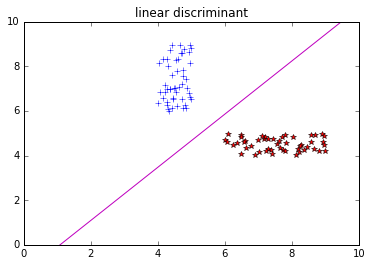

In [4]:
def lin_discr(X, N1, draw=True):
    N2 = X.shape[0]-N1
    X_ = np.hstack((np.ones(X.shape[0]).reshape(-1,1),X))
    T1 = np.tile(np.array([1,0]),(N1,1))
    T2 = np.tile(np.array([0,1]),(N2,1))
    T = np.vstack((T1,T2))

    W = np.dot(np.linalg.pinv(X_),T)
    Discr = W[:,0] - W[:,1]

    if draw:
        draw_points(X, N1, [0,10], [0,10], title_='linear discriminant')
        x_ = np.arange(0,10,1e-1)
        y_ = (-x_*Discr[1]-Discr[0])/Discr[2]
        plt.plot(x_, y_, 'm-')
        
    return W

X, R, N1, N2 = gen_data()
lin_discr(X, N1)

## 2- Fisher's Linear Discriminant

One interpretation of the linear discriminant is the following: We project each data point $\mathbf{x}$ into one dimension by setting $y=\mathbf{w}^T\mathbf{x}$ and classify by thresholding: $\mathbf{x} \in C_1$ if $y\geq w_0$; $\mathbf{x} \in C_2$, otherwise. Our hope was that by adjusting $\mathbf{w}$, we can select a projection that gives maximum separation. 

Let us start with $N_1$ data points in the first class and $N_2$ data points in the second one. Let us define class mean vectors as follows:
\begin{align}
    \mathbf{m}_1 = \frac{1}{N_1} \sum_{n \in C_1} \mathbf{x}_n,\quad\quad\quad  \mathbf{m}_2 = \frac{1}{N_2} \sum_{n \in C_2} \mathbf{x}_n,\quad\quad\quad m_k=\mathbf{w}^T\mathbf{m}_k,\quad\quad\quad m_2-m_1=\mathbf{w}^T(\mathbf{m}_2-\mathbf{m}_1)
\end{align}

The goal is to separate means as much as possible, so we want $\mathbf{w}^T(\mathbf{m}_2-\mathbf{m}_1)$ to be large. When $\mathbf{w}$ is a unit vector, the solution is simply $\mathbf{w} \propto (\mathbf{m}_2-\mathbf{m}_1)$. However, the problem arises from the strongly nondiagonal covariances of the class distributions. The idea proposed by Fisher is to maximize a function that will give a large separation between the projected class means while also giving a small variance within each class, thereby minimizing the class overlap. The Fisher criterion is defined to be the ratio of the between-class variance to the within-class variance and is given by:
\begin{align}
    s_k^2 &= \sum_{n\in C_k} (y_n-m_k)^2 \quad\text{(within class variance)} \\
    J(\mathbf{w}) &= \frac{(m_2-m_1)^2}{s_1^2 + s_2^2} \\
    &= \frac{(\mathbf{w}^T(\mathbf{m}_2-\mathbf{m}_1))^2}{\sum_{n\in C_1} (\mathbf{w}^T\mathbf{x}_n-\mathbf{w}^T\mathbf{m}_1)^2 + \sum_{n\in C_2} (\mathbf{w}^T\mathbf{x}_n-\mathbf{w}^T\mathbf{m}_2)^2}  \\
    &= \frac{\mathbf{w}^T\mathbf{S}_B\mathbf{w}}{\mathbf{w}^T\mathbf{S}_W\mathbf{w}}
\end{align}

where $\mathbf{S}_B=(\mathbf{m}_2-\mathbf{m}_1)(\mathbf{m}_2-\mathbf{m}_1)^T$ and $\mathbf{S}_W=\sum_{n\in C_1} (\mathbf{x}_n-\mathbf{m}_1)(\mathbf{x}_n-\mathbf{m}_1)^T + \sum_{n\in C_2} (\mathbf{x}_n-\mathbf{m}_2)(\mathbf{x}_n-\mathbf{m}_2)^T$ are *between-class* and *within class* covariance matrices.

Differentiating $J(\mathbf{w})$ wrt $\mathbf{w}$, we end up with 
\begin{align}
    (\mathbf{w}^T\mathbf{S}_B\mathbf{w})\mathbf{S}_W\mathbf{w} = (\mathbf{w}^T\mathbf{S}_W\mathbf{w})\mathbf{S}_B\mathbf{w}
\end{align}

From the definition of $\mathbf{S}_B$, we do see that $\mathbf{S}_B\mathbf{w}$ is always in the direction of $(\mathbf{m}_2-\mathbf{m}_1)$. We thus conclude that
\begin{align}
    \mathbf{w} \propto \mathbf{S}_W^{-1} (\mathbf{m}_2-\mathbf{m}_1)
\end{align}
We classify a new point as belonging to $C_1$ if $y(\mathbf{x}) \geq y_0$ and classify it belonging to $C_2$ otherwise. For example, we can model the class-conditional densities $p(y|C_k)$ using Gaussian distributions.

Red/Blue values are the histograms of one dimensional projections of class 1/2


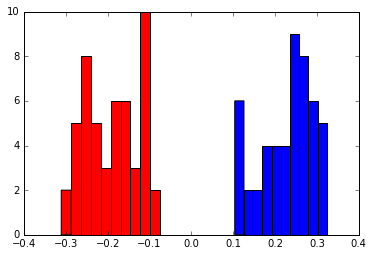

In [5]:
def fisher_lin_discr(X, N1, draw=False):
    N2 = X.shape[0]-N1
    S1 = X[:N1,:]
    S2 = X[N1:,:]
    
    m1 = S1.sum(0)/N1 # cluster center 1
    m2 = S2.sum(0)/N2 # cluster center 2

    Sw = np.zeros((2,2))
    for i in range(N1):
        tmp = S1[i,:]-m1
        Sw += np.outer(tmp,tmp)
    for i in range(N2):
        tmp = S2[i,:]-m2
        Sw += np.outer(tmp,tmp)

    w = np.dot(np.linalg.inv(Sw),(m2-m1))
    Xw = np.dot(X,w)
    
    if draw:
        print('Red/Blue values are the histograms of one dimensional projections of class 1/2')
        tmp = plt.hist(Xw[:N1],color='red')
        tmp = plt.hist(Xw[N2:],color='blue')
    
    L = np.hstack((np.zeros(N1),np.ones(N2)))
    return np.hstack((Xw.reshape((-1,1)),L.reshape((-1,1))))
    
X, R, N1, N2 = gen_data()
R = fisher_lin_discr(X,N1,draw=True)

## 3- Probabilistic Generative Models

In this section, we shall adopt a generative approach in which we model the class-conditional densities $p(\mathbf{x}|C_k)$, as well as the class priors $p(C_k)$, and then use these to compute the posterior probabilities $p(C_k|\mathbf{x})$ through Bayes' theorem.

First, define sigmoid:
\begin{align}
    \sigma(x) &= \frac{1}{1+\exp(-x)} \\ 
    \frac{d\sigma(x)}{dx} &= \frac{\exp(-x)}{(1+\exp(-x))^2} = \sigma(x) (1-\sigma(x))
\end{align}

We also define the discriminant function as
\begin{align}
    g_k(\mathbf{x}) &= p(\mathbf{x}|C_k)p(C_k) 
\end{align}

Then the posterior probability for class $C_1$ can be written as
\begin{align}
    p(C_1|\mathbf{x}) &= \frac{g_1(\mathbf{x})}{g_1(\mathbf{x}) + g_2(\mathbf{x})} \\
    &= \frac{1}{1+\frac{g_2(\mathbf{x})}{g_1(\mathbf{x})}} \\
    &= \sigma(a)
\end{align} 
where
\begin{align} 
a &= \ln \frac{g_1(\mathbf{x})}{g_2(\mathbf{x})}
\end{align} 

The inverse of logistic sigmoid is known as **logit** function. It represents the log of the ratio of probabilities $a = \ln [p(C_1|\mathbf{x})/p(C_2|\mathbf{x})]$, also known as **log odds**.

\begin{align}
    a &= \ln \frac{\sigma}{1-\sigma}  
\end{align}

For the case $K>2$ classes, we use **softmax** function:
\begin{align}
    p(C_k|\mathbf{x}) = \frac{g_k(\mathbf{x})}{\sum_j g_j(\mathbf{x})}
\end{align}

### Continuous inputs:
Let us assume that the class-conditional densities are Gaussian. Now, let's explore the resulting form for the posterior probabilities:
\begin{align}
    p(\mathbf{x}|C_k) = \frac{1}{(2\pi)^{D/2}} \frac{1}{|\mathbf{\Sigma}|^{1/2}} \exp \left\{ -\frac{1}{2}(\mathbf{x}-\mathbf{\mu}_k)^T\mathbf{\Sigma}^{-1}(\mathbf{x}-\mathbf{\mu}_k) \right\}
\end{align}

#### Shared Covariance: Linear Function for Discrimination
When classes share the same covariance matrix, the computation becomes very easy. Remember that $\sigma(a)$ is equal to the posterior probability of being in class 1. Hence, we simply compute $a$ to get the posterior:
\begin{align}
    a &= \ln \frac{g_1(\mathbf{x})}{g_2(\mathbf{x})} \\
    &= \ln \frac{p(\mathbf{x}|C_1)p(C_1)}{p(\mathbf{x}|C_2)p(C_2)} \\
    &= -\frac{1}{2}(\mathbf{x}-\mathbf{\mu}_1)^T\mathbf{\Sigma}^{-1}(\mathbf{x}-\mathbf{\mu}_1) + \frac{1}{2}(\mathbf{x}-\mathbf{\mu}_2)^T\mathbf{\Sigma}^{-1}(\mathbf{x}-\mathbf{\mu}_2) + \log p(C_1) - \log p(C_2) \\
    &= (\mathbf{\Sigma}^{-1}(\mu_1-\mu_2))^{T}\mathbf{x} + \left( -\frac{1}{2}\mu_1^T\mathbf{\Sigma}^{-1}\mu_1 + \frac{1}{2}\mu_2^T\mathbf{\Sigma}^{-1}\mu_2 + \ln \frac{p(C_1)}{p(C_2)} \right) \\
    &= \mathbf{w}^T\mathbf{x} + w_0
\end{align}

#### Distinct Covariance Matrices: Quadratic Function for Discrimination
In case the covariance matrix is not common, we have quadratic discriminants. Let $\mathbf{S}_1$ and $\mathbf{S}_2$ denote within-class covariance matrices:

\begin{align}
    a &=  \ln \frac{p(\mathbf{x}|C_1)p(C_1)}{p(\mathbf{x}|C_2)p(C_2)} \\
    &= -\frac{1}{2}\log |\mathbf{S}_1| -\frac{1}{2}(\mathbf{x}-\mathbf{\mu}_1)^T\mathbf{S}_1^{-1}(\mathbf{x}-\mathbf{\mu}_1) + \frac{1}{2}\log |\mathbf{S}_2| + \frac{1}{2}(\mathbf{x}-\mathbf{\mu}_2)^T\mathbf{\mathbf{S}_2}^{-1}(\mathbf{x}-\mathbf{\mu}_2) + \log p(C_1) - \log p(C_2) \\
    &= \frac{1}{2}\mathbf{x}^T(\mathbf{S}_2^{-1}-\mathbf{S}_1^{-1})\mathbf{x} +  (\mathbf{S}_1^{-1}\mu_1-\mathbf{S}_2^{-1}\mu_2))^{T}\mathbf{x} + \left( -\frac{1}{2}\mu_1^T\mathbf{\mathbf{S}_1}^{-1}\mu_1 + \frac{1}{2}\mu_2^T\mathbf{\mathbf{S}_2}^{-1}\mu_2 + \ln \frac{p(C_1)}{p(C_2)} - \frac{1}{2} \ln \frac{|\mathbf{S}_1|}{|\mathbf{S}_2|} \right) \\
    &= \mathbf{x}^T\mathbf{W}\mathbf{x} + \mathbf{w}^T\mathbf{x} + w_0
\end{align}

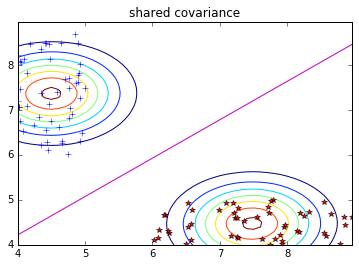

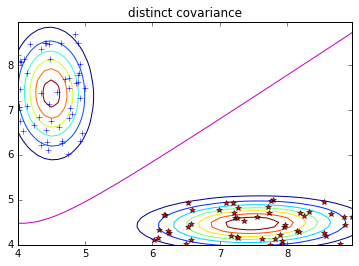

In [6]:
from scipy.stats import multivariate_normal

def plot_cont(X, N1, mean1_, mean2_, cov1_, cov2_, x_disc=None, y_disc=None, title_=''):
    draw_points(X, N1, [np.min(X),np.max(X)], [np.min(X),np.max(X)])

    x, y = np.mgrid[0:10:0.1, 0:10:0.1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    plt.contour(x, y, multivariate_normal.pdf(pos, mean=mean1_, cov=cov1_))
    plt.contour(x, y, multivariate_normal.pdf(pos, mean=mean2_, cov=cov2_))
    plt.title(title_)
    
    if x_disc is not None:
        plt.plot(x_disc, y_disc, 'm-')
        
def boundary(W, w, w0, x):
    a = W[1,1]
    b = x*(W[1,0]+W[0,1]) + w[1]
    c = x*x*W[0,0]+w[0]*x+w0
    return np.roots([a,b,c])
    
    
def prob_gen_classification(X, N1, draw=False):
    N2 = X.shape[0]-N1
    S1 = X[:N1,:]
    S2 = X[N1:,:]
    
    # class priors
    pC1 = N1/(N1+N2)
    pC2 = N2/(N1+N2)

    # means
    m1 = S1.sum(0)/N1 
    m2 = S2.sum(0)/N2 

    # covariance matrices
    cov1 = np.zeros((2,2))
    for i in range(N1):
        tmp = S1[i,:]-m1
        cov1 += np.outer(tmp,tmp)
    cov1 /= N1
    cov2 = np.zeros((2,2))
    for i in range(N2):
        tmp = S2[i,:]-m2
        cov2 += np.outer(tmp,tmp)
    cov2 /= N2

    # shared covariance
    cov = pC1*cov1 + pC2*cov2
    inv_cov = np.linalg.inv(cov)
    w = np.dot(inv_cov,(m1-m2))
    w0 = -0.5*np.dot(np.dot(m1.transpose(),inv_cov),m1) + 0.5*np.dot(np.dot(m2.transpose(),inv_cov),m2) + np.log(pC1/pC2)
    x_disc = np.arange(0,10,1e-1)
    y_disc = (-w0-x_disc*w[0])/w[1]
    if draw:
        plot_cont(X,N1,m1,m2,cov,cov,x_disc,y_disc,title_="shared covariance")

    # distinct covariance
    inv_cov1 = np.linalg.inv(cov1)
    inv_cov2 = np.linalg.inv(cov2)
    W = 0.5*(inv_cov2 - inv_cov1)
    w = np.dot(inv_cov1,m1) - np.dot(inv_cov2,m2)
    w0 = -0.5*np.dot(np.dot(m1.transpose(),inv_cov1),m1) + 0.5*np.dot(np.dot(m2.transpose(),inv_cov2),m2) + np.log(pC1/pC2) - 0.5*np.log(np.linalg.det(cov1)/np.linalg.det(cov2))
    y_disc1 = []
    y_disc2 = []
    for x_ in x_disc:
        tmp = boundary(W, w, w0, x_)
        y_disc1.append(tmp[0])
        y_disc2.append(tmp[1])
    if draw:
        plot_cont(X, N1,m1,m2,cov1,cov2, x_disc, y_disc1,title_="distinct covariance")
    
X, R, N1, N2 = gen_data()
prob_gen_classification(X,N1,draw=True)

## 4- Probabilistic Discriminative Models

An alternative approach to what we have done so far is to use the functional form of the generalized linear model explicitly and to determine its parameters directly by using maximum likelihood. The indirect approach to finding the parameters of a generalized linear model, by fitting class-conditional densities and class priors separately and then applying Bayes’ theorem, represents an example of **generative modelling**, because we could take such a model and generate synthetic data by drawing values of $\mathbf{x}$ from the marginal distribution $p(\mathbf{x})$. In the direct approach, we are maximizing a likelihood function defined through the conditional distribution $p(C_k|\mathbf{x})$, which represents a form of **discriminative training**. One advantage of the discriminative approach is that there will typically be fewer adaptive parameters to be determined, as we shall see shortly. It may also lead to improved predictive performance, particularly when the class-conditional density assumptions give a poor approximation to the true distributions.

### Fixed Basis Functions:
So far in this notebook, all models that we described have been applied to original input vectors $\mathbf{x}$. However, all methods are equally applicable to non-linear transformation of the original data set. The nonlinearlity are usually obtained via basis functions $\phi(\mathbf{x})$. The resulting decision boundaries will be linear in the feature space $\phi$, and these correspond to nonlinear decision boundaries in the original input space. Note that one of the basis functions are typically set to 1: $\phi_0(\mathbf{x})=1$ so that corresponding parameter $w_0$ plays the role of a bias. We are happy when basis functions remove the overlap between class conditional densities $p(\mathbf{x}|C_k)$.

**Gaussian Basis Function**: $\mu_j$ govern the locations of the basis functions in input space, and the parameter $s$ governs their spatial scale:
\begin{align}
    \phi_j(\mathbf{x}) = \exp \left\{ -\frac{(x-\mu_j)^2}{2s^2} \right\}
\end{align}

**Sigmoid Basis**: 
\begin{align}
    \phi_j(\mathbf{x}) = \sigma \left\{ \frac{x-\mu_j}{s} \right\}
\end{align}

### Logistic Regression:
\begin{align}
p(C_1|\phi) &= y(\phi) = \sigma(\mathbf{w}^T\phi) \\
p(C_2|\phi) &= 1-p(C_1|\phi)
\end{align}

We use maximum likelihood to determine the parameters of the logistic regression model. 

For a data set $\{r_n,\phi_n\}$ where
 - $r_n=1$ if $x_n \in C_1$, $r_n=0$ if $x_n \in C_2$, 
 - $\phi_n = \phi(\mathbf{x}_n)$
 - $y_n = \sigma(\mathbf{w}^T\phi_n)$
 - $r_n | \mathbf{x}_n \sim \text{Bernouilli}(y_n)$
 - $n=1\ldots N$
 
the loglikelihood is given by
\begin{align}
\log p(r_{1:N}|\mathbf{w}) &= \sum_{n=1}^N \log p(r_n|\mathbf{w}) \\
&= \sum_{n=1}^N r_n \log y_n + (1-r_n) \log(1-y_n) \\
&= \sum_{n=1}^N r_n \log \sigma(\mathbf{w}^T\phi_n) + (1-r_n) (1-\log \sigma(\mathbf{w}^T\phi_n))
\end{align}

We define the negative log likelihood as the error function, set its derivative wrt $w_j$ to zero. Because we are minimizing the error, we move in the opposite direction of the gradient. In other words, we move in the direction of the gradient of the maximum likelihood expression. 
\begin{align}
\frac{\partial \log p(r_{1:N}|\mathbf{w})}{\partial w_j} &= \frac{\partial \log p(r_{1:N}|\mathbf{w})}{\partial y_n} \frac{\partial y_n}{\partial w_j} \\
&= \sum_{n=1}^N \left( \frac{r_n}{y_n} - \frac{1-r_n}{1-y_n} \right) y_n (1-y_n) \phi_{n,j} \\
&= \sum_{n=1}^N (r_n-y_n) \phi_{n,j} \\
\end{align}

[  8.37164654 -17.42864676  -1.4558266 ]
[ 3.12988988 -6.77752661 -0.35157867]


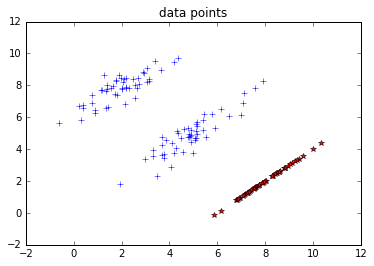

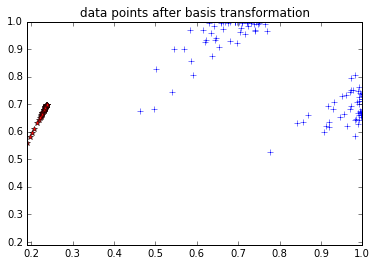

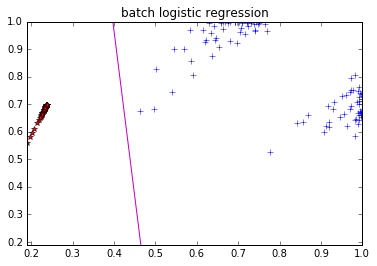

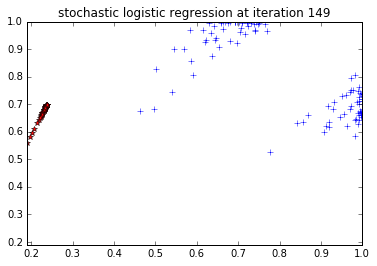

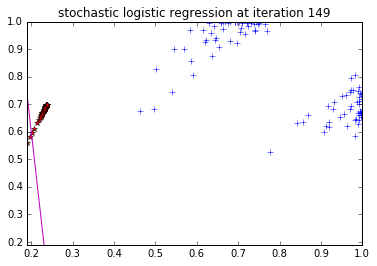

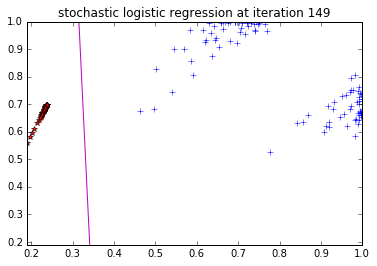

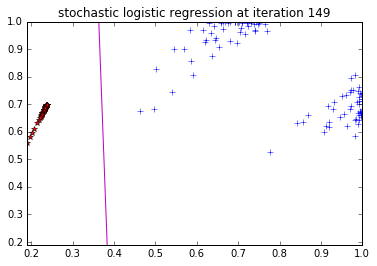

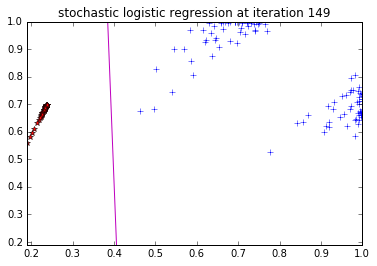

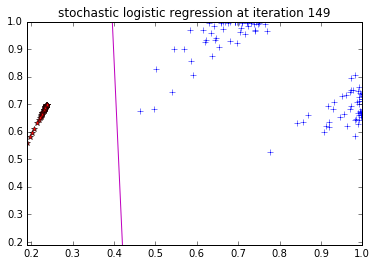

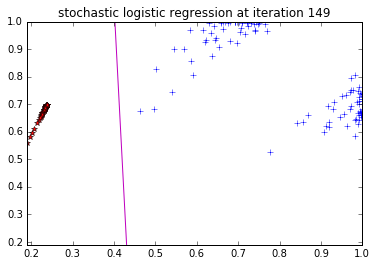

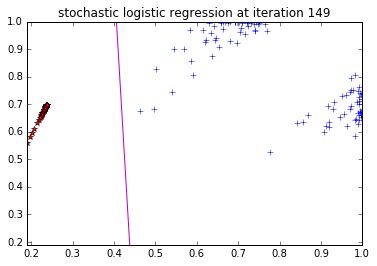

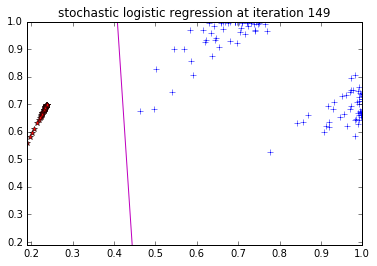

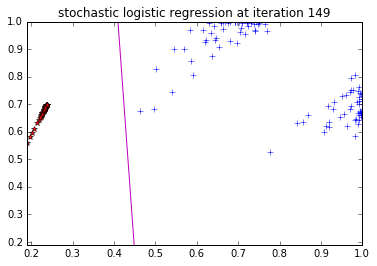

In [7]:
def gaussian_basis(X,mu1,mu2,s1,s2):
    D1 = X - np.tile(mu1,(X.shape[0],1))
    C1 = np.exp(-np.sum(D1*D1,axis=1)/(2*s1*s1))
    D2 = X - np.tile(mu2,(X.shape[0],1))
    C2 = np.exp(-np.sum(D2*D2,axis=1)/(2*s2*s2))
    return np.hstack((C1.reshape((-1,1)),C2.reshape((-1,1))))


def batch_log_reg(phi, N1, draw=False, epoch_=100, eta=0.1):
    phi_ = np.hstack((np.ones((phi.shape[0],1)),phi))
    N2 = phi.shape[0]-N1
    R = np.hstack((np.zeros(N1),np.ones(N2)))
    W = np.random.random(3)*1e-2
    for i in range(epoch_):
        err = R - sigmoid(np.dot(phi_,W))
        grad = np.sum(np.tile(err.reshape((-1,1)),(1,3))*phi_, axis=0)
        W += eta*grad
    if draw:
        draw_points(phi, N1, [np.min(phi),np.max(phi)], [np.min(phi),np.max(phi)], title_="batch logistic regression", W=W)
    return W


def stoch_log_reg(phi, N1, draw=False, epoch_=100, eta=0.01):
    phi_ = np.hstack((np.ones((phi.shape[0],1)),phi))
    N2 = phi.shape[0]-N1
    R = np.hstack((np.zeros(N1),np.ones(N2)))
    W = np.random.random(3)*1e-2
    for i in range(epoch_):
        for j in range(len(R)):
            err = R[j]-sigmoid(np.dot(phi_[j,:],W))
            stoc_grad = phi_[j,:]*err
            W += eta*stoc_grad
            if draw and j==len(R)-1 and i%10==0:
                draw_points(phi, N1, [np.min(phi),np.max(phi)], [np.min(phi),np.max(phi)], title_="stochastic logistic regression at iteration "+str(j), W=W)
        eta = eta*0.999
    return W



X, R, N1, N2 = gen_data_gauss(50,50,50,True)
phi = gaussian_basis(X, [2,8], [5,5], 5, 5)
draw_points(phi, N1, [np.min(phi),np.max(phi)], [np.min(phi),np.max(phi)], title_="data points after basis transformation")

W = batch_log_reg(phi, N1, draw=True)
print(W)
W = stoch_log_reg(phi, N1, draw=True)
print(W)

## 5- Multi Layer Perceptron

 - **input:** $\mathbf{h}^0 = [1, \mathbf{x}^T_n]^T$
 - **intermediate steps:**
   - $\mathbf{z}^1 = W^0 \mathbf{h}^0$, $\mathbf{h}^1 = \sigma(\mathbf{z}^1)$
   - $\mathbf{z}^2 = W^1 \mathbf{h}^1$, $\mathbf{h}^2 = \sigma(\mathbf{z}^2)$
   - $\ldots$
   - $z^{d} = W^{d-1} \mathbf{h}^{d-1}$
 - **output:** $y_n = \sigma(z^{d})$
 
\begin{align}
    y_n &= \sigma(z^d) \\
    &= \sigma(W^{d-1} \mathbf{h}^{d-1}) \\
    &= \sigma(W^{d-1} \sigma(\mathbf{z}^{d-1})) \\
    &= \sigma(W^{d-1} \sigma(W^{d-2} \mathbf{h}^{d-2})) \\
    &= \sigma(W^{d-1} \sigma(W^{d-2} \sigma(\mathbf{z}^{d-2}))) 
\end{align}
 

The loglikelihood is given by
\begin{align}
\log p(r_{1:N}|W^{0:d-1}) &= \sum_{n=1}^N \log p(r_n|W^{0:d-1}) \\
&= \sum_{n=1}^N r_n \log y_n + (1-r_n) \log(1-y_n)
\end{align}

Then, let's define the error function as
\begin{align}
E[W^{0:d-1}|\mathbf{x}_{1:N}] &= -\log p(r_{1:N}|W^{0:d-1},\mathbf{x}_{1:N}) \\
&= -\sum_{n=1}^N \log p(r_{n}|W^{0:d-1},\mathbf{x}_{n})
\end{align}

### MLP with 2 Hidden Units
Here is how input and outputs are connected:
\begin{align}
    y_n &= \sigma(z^2) \\
    &= \sigma(W^{1} \mathbf{h}^{1}) \\
    &= \sigma(W^{1} \sigma(\mathbf{z}^{1})) \\
    &= \sigma(W^{1} \sigma(W^{0} \mathbf{h}^{0}))
\end{align}

Let's compute the derivative for the second layer weights:
\begin{align}
-\eta \frac{\partial E}{\partial W^{1}_{i}} &= \eta \sum_{n=1}^N \frac{\partial E}{y_n}\frac{y_n}{z^2}\frac{z^2}{\partial W^{1}_{i}} \\
&= \eta \sum_{n=1}^N \left( \frac{r_n}{y_n} - \frac{1-r_n}{1-y_n} \right) y_n(1-y_n) \frac{z^2}{\partial W^{1}_{i}} \\
&= \eta \sum_{n=1}^N (r_n-y_n) h^{1}_i
\end{align}

Now, for the first layer weights:
\begin{align}
-\eta \frac{\partial E}{\partial W^{0}_{ij}} &= \eta \sum_{n=1}^N \frac{\partial E}{y_n} \frac{y_n}{z^2} \frac{z^2}{h^1_i} \frac{h^1_i}{z_i^1} \frac{z_i^1}{W^0_{ij}} \\
&= \eta \sum_{n=1}^N \left( \frac{r_n}{y_n} - \frac{1-r_n}{1-y_n} \right) y_n(1-y_n) W^{1}_{i} h^1_i (1-h^1_i) h_j^0 \\
&= \eta \sum_{n=1}^N (r_n-y_n) W^{1}_{i} h^1_i (1-h^1_i) h_j^0
\end{align}


### MLP with 3 Hidden Units (???)
Here is how input and outputs are connected:
\begin{align}
    y_n &= \sigma(z^3) \\
    &= \sigma(W^{2} \mathbf{h}^{2}) \\
    &= \sigma(W^{2} \sigma(\mathbf{z}^{2})) \\
    &= \sigma(W^{2} \sigma(W^{1} \mathbf{h}^{1})) \\
    &= \sigma(W^{2} \sigma(W^{1} \sigma(\mathbf{z}^{1})) \\
    &= \sigma(W^{2} \sigma(W^{1} \sigma(W^{0} \mathbf{h}^{0}))) 
\end{align}

Let's introduce the base case of the recursion for backpropogation:
\begin{align}
\frac{\partial E}{\partial W^{m-1}_{ij}} &= \frac{\partial E}{\partial z_i^m}\frac{\partial z_i^m}{\partial W^{m-1}_{ij}} \\
&= \frac{\partial E}{\partial z_i^m} h_j^{m-1}
\end{align}

Now, we will computer $\partial E/\partial z_i^m$ recursively:
\begin{align}
\delta_i^m &= \frac{\partial E}{\partial z_i^m} \\
\text{For } m=3 &\quad \frac{\partial E}{\partial z_i^3} = \frac{\partial E}{y_n} \frac{y_n}{z_i^3} = r_n-y_n \\
\text{For } m=2 &\quad \frac{\partial E}{\partial z_i^2} = \delta_i^{3} \frac{\partial z_i^3}{\partial z_i^2} = (r_n-y_n) \frac{\partial z_i^3}{\partial h_i^2} \frac{\partial h_i^2}{\partial z_i^2} = (r_n-y_n) W_i^2  h_i^2(1-h_i^2) \\
\end{align}

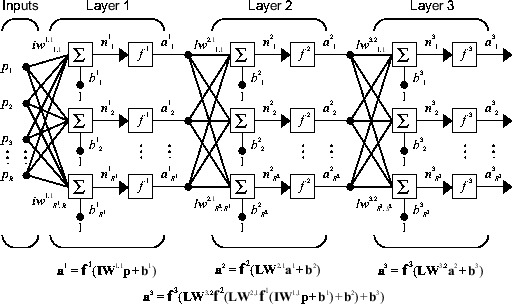

In [8]:
Image(filename='etc/nn.jpg', width=600, height=200)

 - momentum
 - simulated annealing
 - boosting
 - cross validation
 - ensemble methods

# Linear Regression

The simplest linear model for regression is
\begin{align}
y(\mathbf{w},\mathbf{x}) = w_0 + w_1x_1 + \ldots + w_Dx_D
\end{align}

where $\mathbf{x}=(x_1,\ldots,x_D)^T$. This is simply known as *linear regression*. To incorparate nonlinearity, we introduce what's called **basis functions**: $\phi_j(\mathbf{x})$

\begin{align}
y(\mathbf{w},\mathbf{x}) = \sum_{j=0}^{M-1} w_j \phi_j(\mathbf{x}) = \mathbf{w}^T \phi(\mathbf{x})
\end{align}

Note that $\phi_0(\mathbf{x}) := 0$ and the number of model parameters is equal to $M-1$. Such models are referred as *linear models* just because the formulation is linear in $\mathbf{w}$.

**Polynomial Regression:** When the basis functions take the form of powers of x:
\begin{align}
    \phi_j(\mathbf{x}) = x^j
\end{align}
The ordinary least square solution is $\mathbf{w}=(\phi^T\phi)^{-1}\phi^T\mathbf{y}$

**Gaussian Basis Function**: $\mu_j$ govern the locations of the basis functions in input space, and the parameter $s$ governs their spatial scale:
\begin{align}
    \phi_j(\mathbf{x}) = \exp \left\{ -\frac{(x-\mu_j)^2}{2s^2} \right\}
\end{align}

**Sigmoid Basis**: 
\begin{align}
    \phi_j(\mathbf{x}) = \sigma \left\{ \frac{x-\mu_j}{s} \right\}
\end{align}
where logistic sigmoid function $\sigma(a)$ is defined as follows:
\begin{align}
    \sigma(a) = \frac{1}{1+\exp(-a)} 
\end{align}